# Chapter 10. Working With Data

## Exploring Your Data

### Exploring One-Dimensional Data

The simplest case is when you have a one-dimensional data set, which is just a collection of numbers.  
A good first step is to compute some summary statistics, such as the number of data points, the smallest, the largest, the mean, and the standard deviation.  
A good next step is to create a histogram where your data are grouped into discrete *buckets*.

In [32]:
import math
import matplotlib.pyplot as plt
from collections import Counter
from __future__ import division

def bucketize(point, bucket_size):
    """ floor the point to the next lower multiple of bucket_size """
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    """ put the points in buckets and count how many in each bucket """
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

For example, consider the following two sets of data:

In [33]:
import random
from probability import inverse_normal_cdf

random.seed(0)

# uniform distribution between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# normal distibution with mean 0, standard deviation 57
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

Both have means close to 0 and standard deviations close to 58.  
However, they have very different distributions.

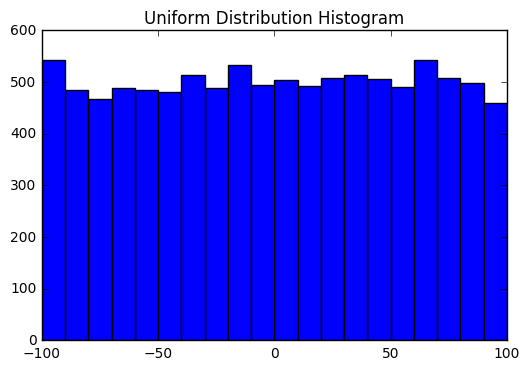

In [34]:
plot_histogram(uniform, 10, "Uniform Distribution Histogram")

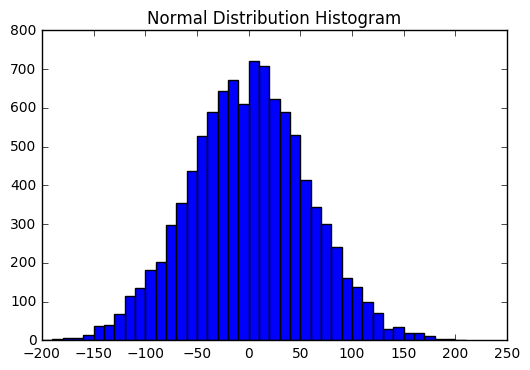

In [35]:
plot_histogram(normal, 10, "Normal Distribution Histogram")

In this case, both distributions had a pretty different `max` and `min`, but even knowing that would not have been sufficient to understand *how* they differed without plotting the data.

### Two Dimensions

When you have a data set with two dimensions, you want to understand each dimension individually, but you would also want to scatter the data.  
To illustrate the idea of scattering the data, let's create a two-dimensional data set:

In [36]:
def random_normal():
    """ returns a random draw from a standard normal distribution """
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(5000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

When you run `plot_histogram` on `ys1` and `ys2`, you get very similar looking plots because they are both normally distributed with the same mean and standard deviation.

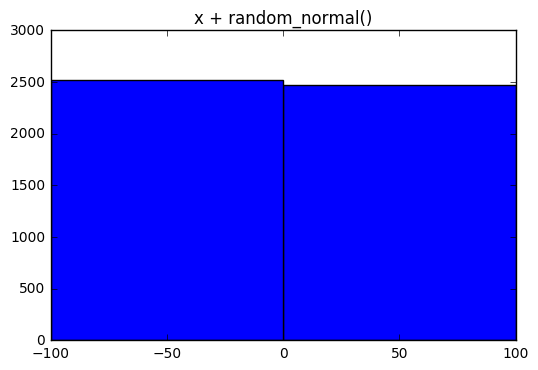

In [37]:
plot_histogram(ys1, 100, "x + random_normal()")

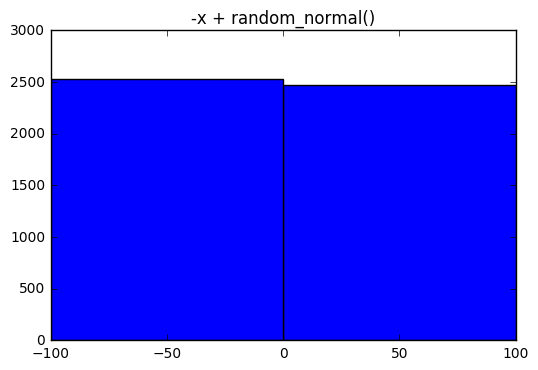

In [38]:
plot_histogram(ys2, 100, "-x + random_normal()")

However, each has a very different joint distribution with `xs`, as we shall illustrate below:

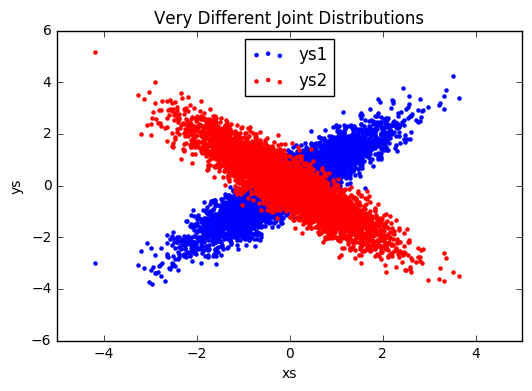

In [39]:
plt.scatter(xs, ys1, marker='.', color='blue', label='ys1')
plt.scatter(xs, ys2, marker='.', color='red', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

The differences are also made apparent when you examine the correlations:

In [40]:
from statistics import correlation

print correlation(xs, ys1)

0.897293439441


In [41]:
print correlation(xs, ys2)

-0.890919845742


### Many Dimensions